# MoSDeF: A Molecular Simulation and Design Framework

The Molecular Simulation and Design Framework (MoSDeF) is a collection of open-source tools ([hosted on Github](https://github.com/mosdef-hub)) aimed at facilitating the construction and simulation of complex molecular systems - with a particular focus on the automated screening of large structural parameter spaces. All tools are written as Python packages and feature a Python-based API.

## Advanced mBuild routines

Now that we've explored the basics of how to create and connect mBuild `Compounds`, we'll look at some more advanced functionality to faciliate the construction of more relevant molecular systems.

### Importing mBuild

Again, we'll import mBuild along with a visualization routine.

In [1]:
%matplotlib notebook
from visualize import visualize
import mbuild as mb

### Creating polymers

In the previous tutorial we finished up by creating a class for constructing a linear alkane chain. One could imagine that the same approach we took to create this class (i.e. successively adding CH2 units) could be further generalized to support the creation of any linear polymer. In fact, mBuild contains a class that does just this, `mbuild.Polymer`.

Here, we'll explore how `Polymer` works by creating a PEG (polyethylene glycol) molecule. We first need to define classes for our CH2 and oxygen monomer units.

In [2]:
class CH2(mb.Compound):
    def __init__(self):
        super(CH2, self).__init__()
        
        mb.load('ch2.pdb', compound=self)
        carbon = list(self.particles_by_name('C'))[0]
        up_port = mb.Port(anchor=carbon, orientation=[0, 0, 1], separation=0.075)
        down_port = mb.Port(anchor=carbon, orientation=[0, 0, -1], separation=0.075)
        self.add(up_port, label='up')
        self.add(down_port, label='down')

class O(mb.Compound):
    def __init__(self):
        super(O, self).__init__()
        
        self.add(mb.Particle(name='O'))
        up_port = mb.Port(anchor=self[0], orientation=[0, 0, 1], separation=0.075)
        self.add(up_port, 'up')
        down_port = mb.Port(anchor=self[0], orientation=[0, 0, -1], separation=0.075)
        self.add(down_port, 'down')

We'll now feed instances of these two monomers to the `monomers` argument of `Polymer`. We also need to provide a few additional arguments. One of these is the `sequence`, which is provided as a string of characters where each unique character represents one repetition of a monomer. Here, `AAB` means that we want two `CH2`'s for each `O`. We can use the `n` argument to specify the number of times the sequence should be replicated. The `port_labels` argument tells mBuild the names of the two `Ports` to connect when stitching together the polymer.

In [ ]:
peg4 = mb.Polymer(monomers=(CH2(), O()), sequence='AAB', n=4, port_labels=('up', 'down'))
visualize(peg4)

#### Exercise
Change the copolymer repeat unit by changing the `sequence` argument. For example, try `'AAABBBB'`.

### Energy minimization

By this point you have likely noticed that the geometries of some of the molecules we've created may not look entirely realistic (e.g. all backbone atoms featuring 180 degree angles in our PEG molecule). You can solve this issue by placing `Particles` and `Ports` in more realistic locations, either manually or by using energy minimized inputs. 

Alternatively, you can construct a `Compound` and then energy minimize, either through a simulation engine or using the `energy_minimization` function in mBuild (which uses the [Open Babel](http://openbabel.org/dev-api/) toolkit) to yield more realistic geometries for your prototypes.

**Note:** In many cases it is easier to create systems with unrealistic configurations.

In [ ]:
from mbuild.examples import Alkane
hexane = Alkane(6)
visualize(hexane)

In [ ]:
hexane.energy_minimization()

In [ ]:
visualize(hexane)

We can use Python's implemented `help` function to view the docstring of any function or object. Here we'll use this to view the docstring for the `energy_minimization` method.

In [ ]:
help(mb.Compound.energy_minimization)

### Packing boxes

A common routine used for setting up systems is the packing of boxes with some molecule prototype. mBuild features several routines designed around the [PackMol](http://www.ime.unicamp.br/~martinez/packmol/home.shtml) utility to support this functionality. Here we'll use the `fill_box` routine to create a box filled with hexane molecules.

To use the `fill_box` routine, we first need to define the dimensions of the box itself. mBuild features a basic `Box` class for defining orthogonal simulation boxes. Here we'll define a box with dimensions of 3nm x 3nm x 3nm.

In [ ]:
box = mb.Box(lengths=[3, 3, 3])
box = mb.Box(mins=[-1.5, -1.5, -1.5], maxs=[1.5, 1.5, 1.5])
box

We'll now use the `fill_box` routine to place five hexane molecules into our box.

In [ ]:
box = mb.fill_box(hexane, n_compounds=5, box=box)
visualize(box)

### Patterning

It can often be useful to specify the exact locations where molecules should be placed in a system. mBuild's `Pattern` class allows one to generate a set of points in Cartesian space in commonly desired arrangements, such as random and grid-like patterns in both 2D and 3D, as well as uniform points on the surface of a sphere.

We'll explore the `Pattern` class here by arranging hydrogen atoms in various arrangements.

<IPython.core.display.Javascript object>


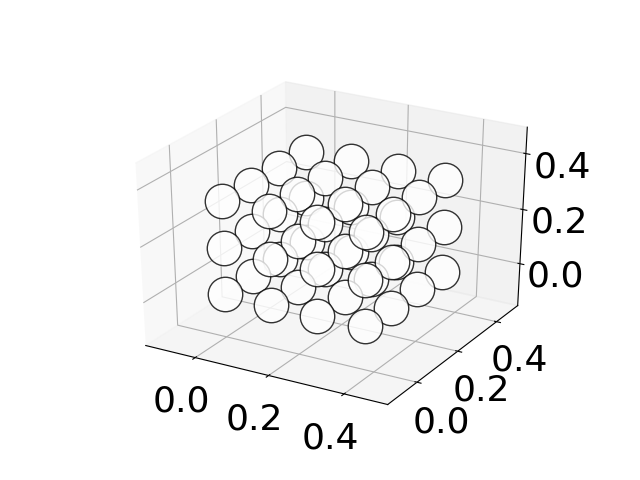

In [3]:
my_compound = mb.Compound()
grid3d = mb.Grid3DPattern(4, 4, 3)
grid3d.scale(0.5)
for position in grid3d:
    particle = mb.Particle(name='H', pos=position)
    my_compound.add(particle)
visualize(my_compound)

<IPython.core.display.Javascript object>


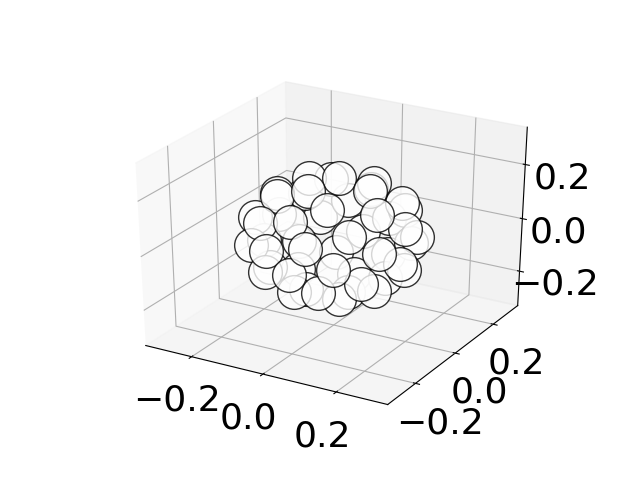

In [4]:
my_compound = mb.Compound()
sphere_pattern = mb.SpherePattern(50)
sphere_pattern.scale(0.2)
for position in sphere_pattern:
    particle = mb.Particle(name='H', pos=position)
    my_compound.add(particle)
visualize(my_compound)

We can also use the `Pattern.apply` method to automatically place copies of a `Compound` at locations specified by a `Pattern`.

<IPython.core.display.Javascript object>


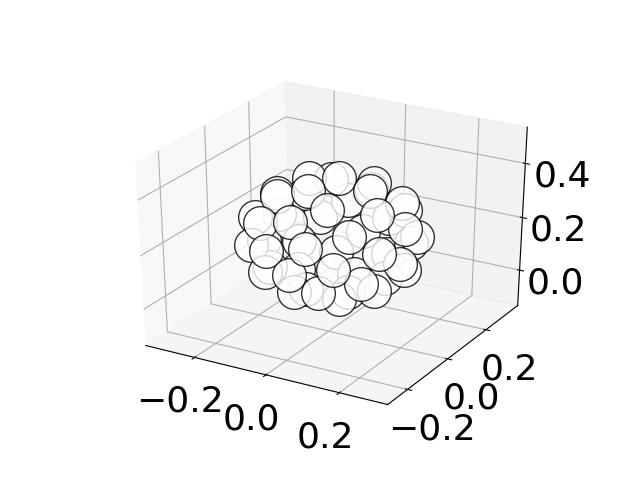

In [5]:
sphere_pattern = mb.SpherePattern(50)
sphere_pattern.scale(0.2)
particle = mb.Particle(name='H', pos=position)
particles = sphere_pattern.apply(particle)
my_compound = mb.Compound(subcompounds=particles)
visualize(my_compound)

### Surface functionalization

mBuild also features several functions to aid in the functionalization of surfaces. For example, the `Pattern.apply_to_compound` method allows one to connect copies of a 'guest' `Compound` to `Ports` located on a 'host' `Compound`. We'll explore how this can be useful for surface functionalization by considering a crystalline silica surface (featuring many `Ports`) as our host and a polymer chain as our guest.

First we'll import our crystalline silica surface from mBuild's `surfaces` library.

/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2108: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2110: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


<IPython.core.display.Javascript object>


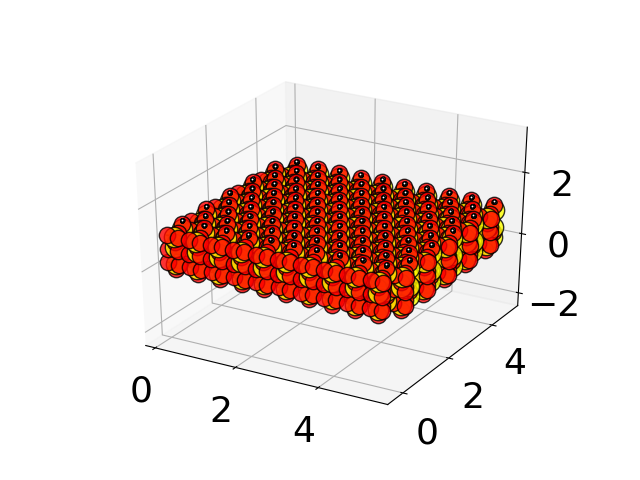

In [6]:
from mbuild.lib.surfaces import Betacristobalite
surface = Betacristobalite()
visualize(surface)

Now, we'll create prototypes for two polymer chains of different lengths, specify a random pattern of 30 points in 2D space, and will use `apply_to_compound` to stick copies of the first polymer on the surface, backfilling unused `Ports` with the shorter polymer. In the mBuild nomenclature, `guests` are the `Compound` copies that have been added to the surface and `backfills` are an optional second `Compound` type that can be used to fill any leftover `Ports` in the host `Compound` after all points in the `Pattern` have been satisfied.

/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2108: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2110: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


<IPython.core.display.Javascript object>


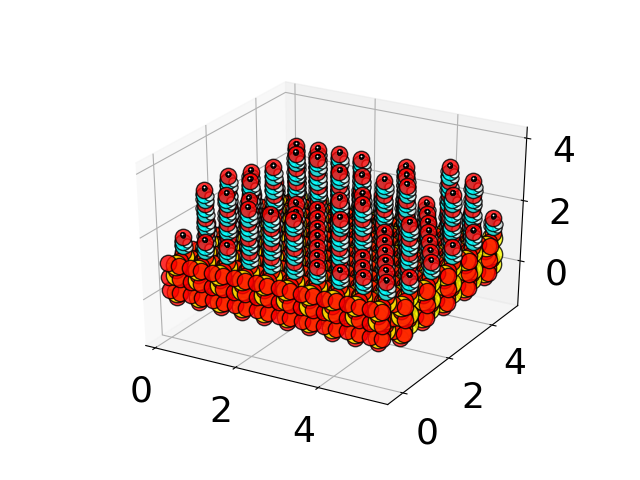

In [7]:
surface = Betacristobalite()
peg4 = mb.Polymer(monomers=(CH2(), O()), n=4, sequence='AAB', port_labels=('up', 'down'))
peg1 = mb.Polymer(monomers=(CH2(), O()), n=1, sequence='AAB', port_labels=('up', 'down'))
pattern = mb.Random2DPattern(30, seed=1)
guests, backfills = pattern.apply_to_compound(guest=peg4, host=surface, backfill=peg1, backfill_port_name='down')
functionalized_surface = mb.Compound(subcompounds=[surface, guests, backfills])
visualize(functionalized_surface)

As we've seen, the `Pattern.apply_to_compound` method is a useful way to approach surface functionalization with mBuild. However, this can be done even easier by using `mbuild.Monolayer`, where the above steps have been wrapped into a class. Multi-component monolayers can be generated by simply passing a list of `Compounds` to the `chains` argument also with the `fractions` of each component.

/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2108: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/summeraz/anaconda/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:2110: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/summeraz/mbuild/mbuild/recipes/monolayer.py:64: UserWarning: 
 Adding 50 of chain <Polymer 28 particles, non-periodic, 27 bonds, id: 4531652928>
  warn("\n Adding {} of chain {}".format(n_points, chain))
/Users/summeraz/mbuild/mbuild/recipes/monolayer.py:64: UserWarning: 
 Adding 40 of chain <Polymer 7 particles, non-periodic, 6 bonds, id: 4934877760>
  warn("\n Adding {} of chain {}".format(n_points, chain))
/Users/summeraz/mbuild/mbuild/recipes/monolayer.py:83: UserWarning: 
 Adding 10 of chain <Polymer 54 particles, non-periodic, 53 bonds, id: 4933116928>
  warn("\n Adding {} of chain {}".format(len(pattern), chains[-1]))


<IPython.core.display.Javascript object>


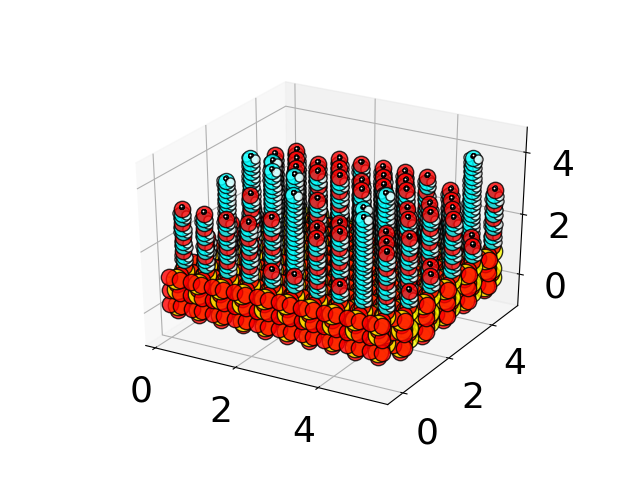

In [8]:
from mbuild.lib.surfaces import Betacristobalite
surface = Betacristobalite()
peg4 = mb.Polymer(monomers=(CH2(), O()), n=4, sequence='AAB', port_labels=('up', 'down'))
peg2 = mb.Polymer(monomers=(CH2(), O()), n=1, sequence='AAB', port_labels=('up', 'down'))
c18 = mb.Polymer(monomers=CH2(), n=18, sequence='A', port_labels=('up', 'down'))
monolayer = mb.Monolayer(surface=surface, chains=(peg4, peg2, c18), fractions=(0.5, 0.4, 0.1))
visualize(monolayer)

These are only a subset of the routines available in mBuild to construct molecular systems, and more routines are continuing to be added. As a reminder, additional information on mBuild can be found both at our [website](http://mosdef-hub.github.io/mbuild/index.html) and our [Github page](https://github.com/mosdef-hub/mbuild). We encourage you to submit "issues" on our Github if there is any additional functionality you would like to see implemented to support creation of systems relevant to your work, or if you are more emboldened, to submit a pull request with routines you have written for mBuild.

### One last demo: Saving molecular topologies

One last demonstration we will examine is how data files can be written from mBuild `Compounds` so that these can be used to run molecules simulations. mBuild utilizes the ParmEd package to support saving mBuild `Compounds` to a variety of common data formats (e.g. PDB, MOL2, GRO) and also features (more limited) writers of its own to save to LAMMPS and HOOMD (both XML and GSD) data formats.

In [2]:
%matplotlib notebook
from visualize import visualize
import mbuild as mb

from mbuild.examples import Alkane
hexane = Alkane(6)
hexane_box = mb.fill_box(hexane, n_compounds=5, box=mb.Box(lengths=[3, 3, 3]))
hexane_box.save('hexanes.gro')
! head hexanes.gro

GROningen MAchine for Chemical Simulation
  100
    1RES      C    1   1.027   0.635   0.428
    1RES      H    2   1.118   0.661   0.371
    1RES      H    3   0.937   0.609   0.485
    1RES      C    4   1.029   0.507   0.370
    1RES      H    5   1.119   0.534   0.314
    1RES      H    6   0.938   0.481   0.427
    1RES      C    7   1.030   0.379   0.313
    1RES      H    8   1.120   0.406   0.257


The next tool in the MoSDeF toolkit we will cover is the Foyer package, which is used to automatically perform atomtyping and forcefield application. This is necessary to actually be able to run simulations using `Compounds` built using mBuild.

Our final code block will show how Foyer can be utilized from within mBuild's `save` function to automatically apply a user-specified forcefield (in this case the OPLS all-atom forcefield).

In [3]:
hexane_box.save('hexanes.top', forcefield_files='../foyer-examples/forcefield_master.xml')

/Users/cri/Projects/plyplus/plyplus/plyplus.py:758: DeprecationWarning: invalid escape sequence '\.'
  return codecs.getdecoder('unicode_escape')(token_value)[0]
/Users/cri/Projects/plyplus/plyplus/plyplus.py:758: DeprecationWarning: invalid escape sequence '\d'
  return codecs.getdecoder('unicode_escape')(token_value)[0]
/Users/cri/Projects/plyplus/plyplus/plyplus.py:758: DeprecationWarning: invalid escape sequence '\('
  return codecs.getdecoder('unicode_escape')(token_value)[0]
/Users/cri/Projects/plyplus/plyplus/plyplus.py:758: DeprecationWarning: invalid escape sequence '\)'
  return codecs.getdecoder('unicode_escape')(token_value)[0]
/Users/cri/Projects/plyplus/plyplus/plyplus.py:758: DeprecationWarning: invalid escape sequence '\+'
  return codecs.getdecoder('unicode_escape')(token_value)[0]
/Users/cri/Projects/plyplus/plyplus/plyplus.py:758: DeprecationWarning: invalid escape sequence '\*'
  return codecs.getdecoder('unicode_escape')(token_value)[0]
/Users/cri/Projects/plyplus/

In [ ]:
! cat hexanes.top